In [ ]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [ ]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [ ]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [ ]:
pv = pv.set_index('datetime')

In [ ]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,14,00,tzinfo=tz):]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, feature)
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

In [ ]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = windowDataset(pv_train[['power_scale', 'dwpt', 'rhum', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = windowDataset(pv_test[['power_scale', 'dwpt', 'rhum', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=4)

In [ ]:
len(train_loader)

22

In [ ]:
len(test_loader)

3

# model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm
import random

In [ ]:
'''
input shape: 
    input: (batch, seq_len, num_feature) -> LSTM layer 에서 batch_first=True option 사용했을 때 기준
output shape:
    output: (batch, seq_len, hidden_dim)
    hidden_state: (batch, 1, hidden_dim) -> 각 batch 마다 제일 마지막 seq_len 기준
    cell_state: (batch, 1, hidden_dim)
'''

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [ ]:
'''
input_shape
    input: (batch, 1, num_feature) -> 직전 timestamp 기준 데이터
    hidden_state: (batch, 1, hidden_dim)
    cell_state: (batch, 1, hidden_dim)
'''

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden

In [ ]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        # print(f"encoder input: {inputs.shape}")

        _, hidden = self.encoder(inputs)
        # print(f"encoder output: {hidden[0].shape}")

        decoder_input = inputs[:,-1,:] # 각 batch 마다 마지막 time stamp 를 decoder의 input 으로 사용
        # print(f"decoder input: {decoder_input.shape}")

        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        # print(f"decoder_output: {outputs.shape}")
        return outputs


In [ ]:
def train(train_loader, epochs=10):
    model.train()

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        total_loss = 0.0

        for x, y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        pbar.set_postfix(loss=f"{(total_loss/len(train_loader)):.5f}")

def predict(test_loader, file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    for t, (x, y) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y = y.to(device).float()
        output = model(x, y, ow, 0).to(device)
        # print(output.shape)
        # outputs[t,:,:,:] = output
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(output, y)
        total_loss += loss.cpu().item()

    print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[]))

In [ ]:
device='cuda'
model = lstm_encoder_decoder(input_size=5, hidden_size=16).to(device)

In [ ]:
learning_rate=0.001
epoch = 1000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [ ]:
train(train_loader, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
pred, true = predict(test_loader)

test loss: 0.01702


In [ ]:
pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [ ]:
pv['pred'] = None
pv['true'] = None
pv.loc[datetime(2006,12,21,00,tzinfo=tz):,'pred'] = pred.reshape(-1)
pv.loc[datetime(2006,12,21,00,tzinfo=tz):,'true'] = true.reshape(-1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


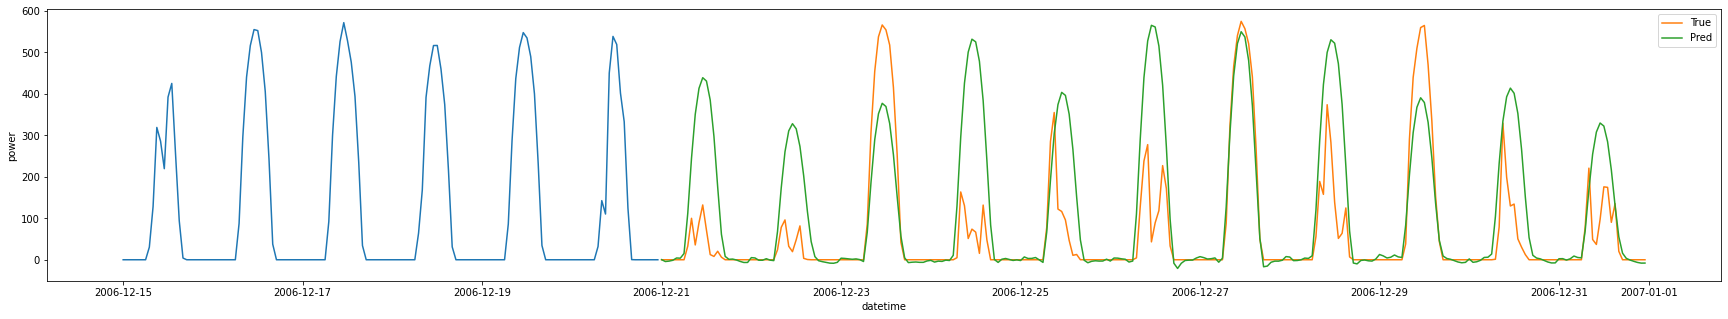

In [ ]:
import seaborn as sns

plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):]['power'])

pv_plot = pv.loc[datetime(2006,12,21,00,tzinfo=tz):]
sns.lineplot(pv_plot.index, pv_plot['true'], label='True')
sns.lineplot(pv_plot.index, pv_plot['pred'], label='Pred')
plt.legend()